### Naive Bayes Binary Classification on HTRU2 Pulsar Data

In [2]:
#Import all the things

import numpy as np
import os
import warnings
warnings.filterwarnings('ignore')
from timeit import default_timer as timer

from sklearn.naive_bayes import GaussianNB
from sklearn import metrics, model_selection, preprocessing
from sklearn.metrics import plot_confusion_matrix
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from itertools import cycle, islice

import seaborn as sns
import plotly as py
import plotly.express as px
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import joblib
import pickle
import pandas

import imblearn

In [3]:
#Read in data 

path = "../data"

pulsar_data = pd.read_csv(path + "/input/HTRU2/HTRU_2.csv", 
                          low_memory=False, index_col=False, header=0, 
                          names=["mean_IP", "standDev_IP", "excessKurt_IP", "skewness_IP", 
                                 "mean_DMSNR", "standDev_DMSNR", "excessKurt_DMSNR", "skewness_DMSNR", "pulsar"])
#print(pulsar_data.head())

### Generate Training/Test Data - Paper Splits, 3-fold, 5-fold, 10-fold Cross Validation

In [4]:
#GENERATE TRAINING/TEST DATA ACCORDING TO SPLITS IN PAPER

#Get data frame of just pulsar and just noise
confirmed_pulsar = pulsar_data[pulsar_data['pulsar'] == 1]
confirmed_noise = pulsar_data[pulsar_data['pulsar'] == 0]

#Split data into training sets based on splits in paper
positive_train_paper_split = confirmed_pulsar.iloc[:200]
negative_train_paper_split = confirmed_noise.iloc[:200]
positive_test_paper_split = confirmed_pulsar.iloc[200:]
negative_test_paper_split = confirmed_noise.iloc[200:]

#Merge positive and negative splits
train_paper_split = pd.concat([positive_train_paper_split, negative_train_paper_split],
                               ignore_index=True, sort=False)
test_paper_split = pd.concat([positive_test_paper_split, negative_test_paper_split],
                               ignore_index=True, sort=False)
#???
train_paper_split = train_paper_split.sample(frac=1).reset_index(drop=True)
test_paper_split = test_paper_split.sample(frac=1).reset_index(drop=True)

#Separate data from labels
X_train_paper_split = train_paper_split.iloc[:, :8]
X_test_paper_split = test_paper_split.iloc[:, :8]
y_train_paper_split = train_paper_split.iloc[:, 8]
y_test_paper_split = test_paper_split.iloc[:, 8]

#Display training/testing sets
#print(X_train_paper_split.shape)
#print(X_train_paper_split.head())
#print(X_test_paper_split.shape)
#print(X_test_paper_split.head())
#print(y_train_paper_split.shape)
#print(y_train_paper_split.head())
#print(y_test_paper_split.shape)
#print(y_test_paper_split.head())

In [5]:
#GENERATE TEST/TRAINING DATA USING SPLITS FROM k-fold CROSS VALIDATION

#Separate data from labesl
X, y = pulsar_data.iloc[:, :8], pulsar_data.iloc[:, 8]

#print(X.head())
#print(y.head())

#Split data for 3-fold cross validation
X_train_3fold, X_test_3fold, y_train_3fold, y_test_3fold = model_selection.train_test_split(X, y, test_size=0.33, 
                                                                            random_state=42, stratify=y)
#Split data for 5-fold cross validation
X_train_5fold, X_test_5fold, y_train_5fold, y_test_5fold = model_selection.train_test_split(X, y, test_size=0.2, 
                                                                            random_state=42, stratify=y)

#Split data for 10-fold cross validation
X_train_10fold, X_test_10fold, y_train_10fold, y_test_10fold = model_selection.train_test_split(X, y, test_size=0.1, 
                                                                            random_state=42, stratify=y)

### Paper Split - ??

In [6]:
#USE GRIDSEARCH TO GENERATE BEST HYPERPARAMS FOR MODEL
#Using splits from paper

#Specify Hyperparameters - Gaussian NB only has var_smoothing and priors (which is not useful in this case)
params = {'var_smoothing': np.logspace(0,-9, num=100)}

#Get model for data splits
skf =  model_selection.StratifiedKFold(n_splits=2, shuffle = True, random_state = 1001)

gnb = GaussianNB()

#Determine best hyperparameters given split and classifier method
grid =  model_selection.GridSearchCV(estimator=gnb, param_grid=params, scoring='f1', n_jobs=-1, cv=skf.split(X_train_paper_split, y_train_paper_split), verbose=3)
grid.fit(X_train_paper_split, y_train_paper_split)

#Print best hyper parameter and model results
print(grid.best_params_)
print(grid.best_estimator_)

Fitting 2 folds for each of 100 candidates, totalling 200 fits
{'var_smoothing': 4.328761281083062e-05}
GaussianNB(var_smoothing=4.328761281083062e-05)


In [7]:
#GENERATE/TRAIN MODEL USING BEST HYPER PARAMETERS
#For splits based on paper

gnb = GaussianNB(var_smoothing = grid.best_params_.get('var_smoothing'))

startTrain = timer()
model = gnb.fit(X_train_paper_split, y_train_paper_split)
endTrain = timer()

#print(endTrain -  startTrain)

Accuracy: 91.88%
auc: 89.82%
Naive Bayes Confusion Matrix: Paper Split
[[14819  1239]
 [  182  1257]]


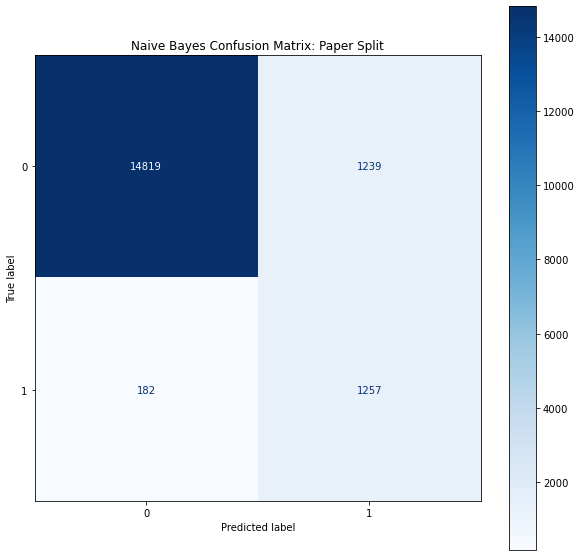

In [8]:
#PRINT ANALYSIS OF RESULTS
#Using splits from paper

y_pred = model.predict(X_test_paper_split)
predictions = [round(value) for value in y_pred]

#Accuracy
accuracy = metrics.accuracy_score(y_test_paper_split, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

#auc
auc = metrics.roc_auc_score(y_test_paper_split, predictions)
print("auc: %.2f%%" % (auc * 100.0))

plt.rcParams['figure.figsize'] = [10, 10]

#Confusion Matrix
disp = plot_confusion_matrix(model, X_test_paper_split, y_test_paper_split,
                                 cmap=plt.cm.Blues)
tn, fp, fn, tp = metrics.confusion_matrix(y_test_paper_split, predictions).ravel()

title = "Naive Bayes Confusion Matrix: Paper Split"
disp.ax_.set_title(title)

print(title)
print(disp.confusion_matrix)

plt.savefig(path + "/output/NB_PaperSplit_Confusion.png", bbox_inches='tight')
plt.show()

In [9]:
#G-Mean - ??
gmean = imblearn.metrics.geometric_mean_score(y_test_paper_split, predictions)
print("Geometric mean: " + str(gmean))

#F-score
fscore = metrics.f1_score(y_test_paper_split, predictions)
print("F-score: " + str(fscore))

#Recall
recall = metrics.recall_score(y_test_paper_split, predictions)
print("Recall: " + str(recall))

#Precision
precision = metrics.precision_score(y_test_paper_split, predictions)
print("Precision: " + str(precision))

#Specificity
specificity = tn / (tn + fp)
print("Specificity: " + str(specificity))

#FPR
fpr = fp / (fp + tn)
print("False positive rate: " + str(fpr))

#Accuracy
accuracy = metrics.accuracy_score(y_test_paper_split, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

#auc
auc = metrics.roc_auc_score(y_test_paper_split, predictions)
print("auc: %.2f%%" % (auc * 100.0))

d = {'gmean' : [gmean], 'fscore' : [fscore], 'recall' : [recall], 'precision' : [precision], 'specificity' : [specificity], 'fpr' : [fpr], 'accuracy' : [accuracy], 'roc_auc' : [auc]}
df = pd.DataFrame(data=d)

df.to_csv (path + "/output/NB_metrics_papersplit.csv", index = False, header=True)

Geometric mean: 0.8978441640554197
F-score: 0.638881829733164
Recall: 0.8735232800555942
Precision: 0.5036057692307693
Specificity: 0.9228421970357454
False positive rate: 0.07715780296425458
Accuracy: 91.88%
auc: 89.82%


### 3-fold Cross Validation

In [10]:
#GENERATE NAIVE BAYES CLASSIFICATION MODEL AND TUNE HYPERPARAMETERS USING GRIDSEARCHCV
#FOR 3-fold

#Specify Hyperparameters - Gaussian NB only has var_smoothing and priors (which is not useful in this case)
params = {'var_smoothing': np.logspace(0,-9, num=100)}

#Generate k-fold cross validation model
skf =  model_selection.StratifiedKFold(n_splits=3, shuffle = True, random_state = 1001)

#Generate classification model
#xgb = XGBClassifier(learning_rate=0.02, n_estimators=600, objective='binary:logistic', use_label_encoder=False, eval_metric='logloss')
gnb = GaussianNB()

#Generate gridsearch model to tune hyperparameters
grid =  model_selection.GridSearchCV(estimator=gnb, param_grid=params, scoring='f1', n_jobs=-1, cv=skf.split(X_train_3fold, y_train_3fold), verbose=3)
grid.fit(X_train_3fold, y_train_3fold) #Fit the model using training data

print(grid.best_params_)
print(grid.best_estimator_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
{'var_smoothing': 5.336699231206302e-08}
GaussianNB(var_smoothing=5.336699231206302e-08)


In [11]:
#GENERATE NEW MODEL BASED ON BEST HYPERPARAMS FOUND BY GRIDSEARCH (THIS IS THE BEST MODEL)
#Using k-fold cross validation splits

gnb = GaussianNB(var_smoothing = grid.best_params_.get('var_smoothing'))

startTrain = timer()
model = gnb.fit(X_train_3fold, y_train_3fold)
endTrain = timer()

#print(endTrain -  startTrain) #Show time taken to train model

Accuracy: 94.40%
auc: 91.10%
Naive Bayes Confusion Matrix: 3 Fold CV
[[5105  261]
 [  70  471]]


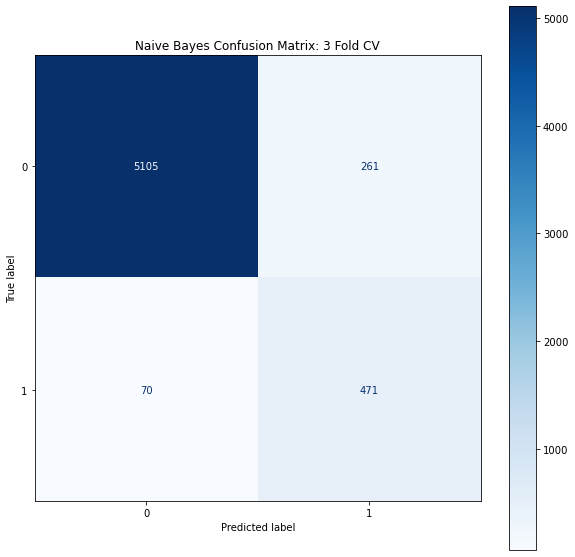

In [12]:
#DISPLAY QUALITY OF RESULTS
#Using k-fold cross validation splits

#Get models results
y_pred = model.predict(X_test_3fold)
predictions = [round(value) for value in y_pred]

#Print accuracy - EQUATION?
accuracy = metrics.accuracy_score(y_test_3fold, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

#auc
auc = metrics.roc_auc_score(y_test_3fold, predictions)
print("auc: %.2f%%" % (auc * 100.0))

plt.rcParams['figure.figsize'] = [10, 10]

#Confusion Matrix
disp = plot_confusion_matrix(model, X_test_3fold, y_test_3fold,
                                 cmap=plt.cm.Blues)
tn, fp, fn, tp = metrics.confusion_matrix(y_test_3fold, predictions).ravel()

title = "Naive Bayes Confusion Matrix: 3 Fold CV"
disp.ax_.set_title(title)

print(title)
print(disp.confusion_matrix)

plt.savefig(path + "/output/NB_3fold_Confusion.png", bbox_inches='tight')
plt.show()

In [13]:
#G-Mean
gmean = imblearn.metrics.geometric_mean_score(y_test_3fold, predictions)
print("Geometric mean: " + str(gmean))

#F-score
fscore = metrics.f1_score(y_test_3fold, predictions)
print("F-score: " + str(fscore))

#Recall
recall = metrics.recall_score(y_test_3fold, predictions)
print("Recall: " + str(recall))

#Precision
precision = metrics.precision_score(y_test_3fold, predictions)
print("Precision: " + str(precision))

#Specificity
specificity = tn / (tn + fp)
print("Specificity: " + str(specificity))

#FPR
fpr = fp / (fp + tn)
print("False positive rate: " + str(fpr))

#Accuracy
accuracy = metrics.accuracy_score(y_test_3fold, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

#auc
auc = metrics.roc_auc_score(y_test_3fold, predictions)
print("auc: %.2f%%" % (auc * 100.0))

d = {'gmean' : [gmean], 'fscore' : [fscore], 'recall' : [recall], 'precision' : [precision], 'specificity' : [specificity], 'fpr' : [fpr], 'accuracy' : [accuracy], 'roc_auc' : [auc]}
df = pd.DataFrame(data=d)

df.to_csv (path + "/output/NB_metrics_3fold.csv", index = False, header=True)

Geometric mean: 0.9100900369990707
F-score: 0.7399842890809112
Recall: 0.8706099815157117
Precision: 0.6434426229508197
Specificity: 0.9513604174431607
False positive rate: 0.04863958255683936
Accuracy: 94.40%
auc: 91.10%


### 5-Fold Cross Validation

In [14]:
#GENERATE NAIVE BAYES CLASSIFICATION MODEL AND TUNE HYPERPARAMETERS USING GRIDSEARCHCV
#FOR 5-fold

#Specify Hyperparameters - Gaussian NB only has var_smoothing and priors (which is not useful in this case)
params = {'var_smoothing': np.logspace(0,-9, num=100)}

#Generate 5-fold cross validation model
skf =  model_selection.StratifiedKFold(n_splits=5, shuffle = True, random_state = 1001)

#Generate classification model
gnb = GaussianNB()

#Generate gridsearch model to tune hyperparameters
grid =  model_selection.GridSearchCV(estimator=gnb, param_grid=params, scoring='f1', n_jobs=-1, cv=skf.split(X_train_5fold, y_train_5fold), verbose=3)
grid.fit(X_train_5fold, y_train_5fold) #Fit the model using training data

print(grid.best_params_)
print(grid.best_estimator_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
{'var_smoothing': 8.111308307896872e-07}
GaussianNB(var_smoothing=8.111308307896872e-07)


In [15]:
#GENERATE NEW MODEL BASED ON BEST HYPERPARAMS FOUND BY GRIDSEARCH (THIS IS THE BEST MODEL)
#Using k-fold cross validation splits

gnb = GaussianNB(var_smoothing = grid.best_params_.get('var_smoothing'))

startTrain = timer()
model = gnb.fit(X_train_5fold, y_train_5fold)
endTrain = timer()

#print(endTrain -  startTrain) #Show time taken to train model

Accuracy: 94.25%
auc: 90.80%
Naive Bayes Confusion Matrix: 5 Fold CV
[[3090  162]
 [  44  284]]


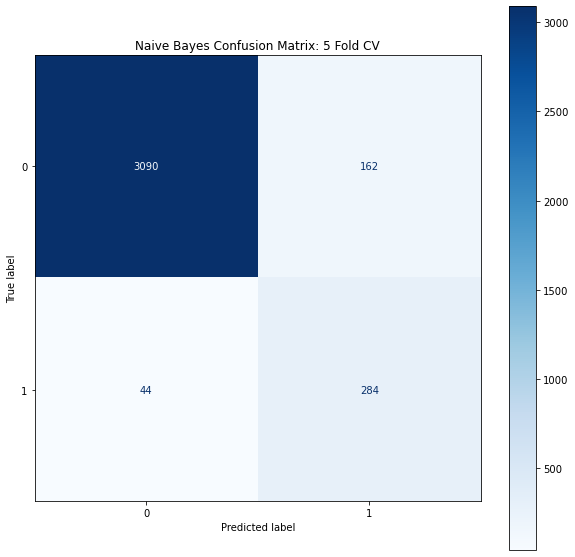

In [16]:
#DISPLAY QUALITY OF RESULTS
#Using k-fold cross validation splits

#Get models results
y_pred = model.predict(X_test_5fold)
predictions = [round(value) for value in y_pred]

#Print accuracy - EQUATION?
accuracy = metrics.accuracy_score(y_test_5fold, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

#auc
auc = metrics.roc_auc_score(y_test_5fold, predictions)
print("auc: %.2f%%" % (auc * 100.0))

plt.rcParams['figure.figsize'] = [10, 10]

#Confusion Matrix
disp = plot_confusion_matrix(model, X_test_5fold, y_test_5fold,
                                 cmap=plt.cm.Blues)
tn, fp, fn, tp = metrics.confusion_matrix(y_test_5fold, predictions).ravel()

title = "Naive Bayes Confusion Matrix: 5 Fold CV"
disp.ax_.set_title(title)

print(title)
print(disp.confusion_matrix)

plt.savefig(path + "/output/NB_5fold_Confusion.png", bbox_inches='tight')
plt.show()

In [17]:
#G-Mean 
gmean = imblearn.metrics.geometric_mean_score(y_test_5fold, predictions)
print("Geometric mean: " + str(gmean))

#F-score
fscore = metrics.f1_score(y_test_5fold, predictions)
print("F-score: " + str(fscore))

#Recall
recall = metrics.recall_score(y_test_5fold, predictions)
print("Recall: " + str(recall))

#Precision
precision = metrics.precision_score(y_test_5fold, predictions)
print("Precision: " + str(precision))

#Specificity
specificity = tn / (tn + fp)
print("Specificity: " + str(specificity))

#FPR
fpr = fp / (fp + tn)
print("False positive rate: " + str(fpr))

#Accuracy
accuracy = metrics.accuracy_score(y_test_5fold, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

#auc
auc = metrics.roc_auc_score(y_test_5fold, predictions)
print("auc: %.2f%%" % (auc * 100.0))

d = {'gmean' : [gmean], 'fscore' : [fscore], 'recall' : [recall], 'precision' : [precision], 'specificity' : [specificity], 'fpr' : [fpr], 'accuracy' : [accuracy], 'roc_auc' : [auc]}
df = pd.DataFrame(data=d)

df.to_csv (path + "/output/NB_metrics_5fold.csv", index = False, header=True)

Geometric mean: 0.9070395400462276
F-score: 0.7338501291989663
Recall: 0.8658536585365854
Precision: 0.6367713004484304
Specificity: 0.9501845018450185
False positive rate: 0.04981549815498155
Accuracy: 94.25%
auc: 90.80%


### 10-Fold Cross Validation

In [18]:
#GENERATE NAIVE BAYES CLASSIFICATION MODEL AND TUNE HYPERPARAMETERS USING GRIDSEARCHCV
#FOR 10-fold

#Specify Hyperparameters - Gaussian NB only has var_smoothing and priors (which is not useful in this case)
params = {'var_smoothing': np.logspace(0,-9, num=100)}

#Generate 10-fold cross validation model
skf =  model_selection.StratifiedKFold(n_splits=10, shuffle = True, random_state = 1001)

#Generate classification model
gnb = GaussianNB()

#Generate gridsearch model to tune hyperparameters
grid =  model_selection.GridSearchCV(estimator=gnb, param_grid=params, scoring='f1', n_jobs=-1, cv=skf.split(X_train_10fold, y_train_10fold), verbose=3)
grid.fit(X_train_10fold, y_train_10fold) #Fit the model using training data

print(grid.best_params_)
print(grid.best_estimator_)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
{'var_smoothing': 6.579332246575682e-07}
GaussianNB(var_smoothing=6.579332246575682e-07)


In [19]:
#GENERATE NEW MODEL BASED ON BEST HYPERPARAMS FOUND BY GRIDSEARCH (THIS IS THE BEST MODEL)
#Using 10-fold cross validation splits

gnb = GaussianNB(var_smoothing = grid.best_params_.get('var_smoothing'))

startTrain = timer()
model = gnb.fit(X_train_10fold, y_train_10fold)
endTrain = timer()

#print(endTrain -  startTrain) #Show time taken to train model

Accuracy: 94.13%
auc: 90.19%
Naive Bayes Confusion Matrix: 10 Fold CV
[[1545   81]
 [  24  140]]


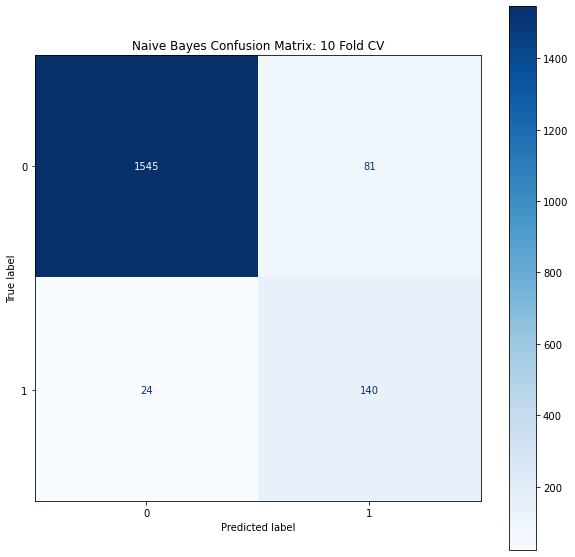

In [20]:
#DISPLAY QUALITY OF RESULTS
#Using 10-fold cross validation splits

#Get models results
y_pred = model.predict(X_test_10fold)
predictions = [round(value) for value in y_pred]

#Print accuracy - EQUATION?
accuracy = metrics.accuracy_score(y_test_10fold, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

#auc
auc = metrics.roc_auc_score(y_test_10fold, predictions)
print("auc: %.2f%%" % (auc * 100.0))

plt.rcParams['figure.figsize'] = [10, 10]

#Confusion Matrix
disp = plot_confusion_matrix(model, X_test_10fold, y_test_10fold,
                                 cmap=plt.cm.Blues)
tn, fp, fn, tp = metrics.confusion_matrix(y_test_10fold, predictions).ravel()
title = "Naive Bayes Confusion Matrix: 10 Fold CV"
disp.ax_.set_title(title)

print(title)
print(disp.confusion_matrix)

plt.savefig(path + "/output/NB_10fold_Confusion.png", bbox_inches='tight')
plt.show()

In [21]:
#G-Mean
gmean = imblearn.metrics.geometric_mean_score(y_test_10fold, predictions)
print("Geometric mean: " + str(gmean))

#F-score
fscore = metrics.f1_score(y_test_10fold, predictions)
print("F-score: " + str(fscore))

#Recall
recall = metrics.recall_score(y_test_10fold, predictions)
print("Recall: " + str(recall))

#Precision
precision = metrics.precision_score(y_test_10fold, predictions)
print("Precision: " + str(precision))

#Specificity
specificity = tn / (tn + fp)
print("Specificity: " + str(specificity))

#FPR
fpr = fp / (fp + tn)
print("False positive rate: " + str(fpr))

#Accuracy
accuracy = metrics.accuracy_score(y_test_10fold, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

#auc
auc = metrics.roc_auc_score(y_test_10fold, predictions)
print("auc: %.2f%%" % (auc * 100.0))

d = {'gmean' : [gmean], 'fscore' : [fscore], 'recall' : [recall], 'precision' : [precision], 'specificity' : [specificity], 'fpr' : [fpr], 'accuracy' : [accuracy], 'roc_auc' : [auc]}
df = pd.DataFrame(data=d)

df.to_csv (path + "/output/NB_metrics_10fold.csv", index = False, header=True)

Geometric mean: 0.9006292862943739
F-score: 0.7272727272727273
Recall: 0.8536585365853658
Precision: 0.6334841628959276
Specificity: 0.9501845018450185
False positive rate: 0.04981549815498155
Accuracy: 94.13%
auc: 90.19%
